In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

#datetime has a weakness that it you need need to count days to subtract or add future dates. this module will cover that weakness
from dateutil.relativedelta import relativedelta
#using days to subtract is doable to get anything less than 1 year. But lets you want to go back 4 years from set date. You will be off if you dont factor leap year.

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(engine, reflect=True)

# reflect the tables


In [6]:
# View all of the classes that automap found
Base.classes.keys()


['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station


In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.

In [10]:
# I want to know the column names as written
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])



id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [11]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23')

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

# Calculate the date one year from the last date in data set.

# query_date = dt.date(2017, 8, 23) - dt.timedelta(days=365)

#both codes the same. But since I went a lot of trouble to get the second one, I am commenting out the one on top. And not delete it.

twelvemonths = dt.date(2017, 8, 23) - relativedelta(years=1)
print("The date from 1 year ago is ", twelvemonths,  ".")

#Using this code is also easier to calculate something more comples like lets say 1 year 5 months and 3 days ago or from now.  The top needs a lot of work from to calculate that in an an accurrate manner. since not all months are 30 days.


The date from 1 year ago is  2016-08-23 .


In [21]:
# Perform a query to retrieve the data and precipitation scores


results = session.query(measurement.date,  measurement.prcp).\
                  filter(measurement.date >= twelvemonths).order_by(measurement.date.asc()).all()




# Save the query results as a Pandas DataFrame and set the index to the date column
PRCP_DF = pd.DataFrame(results, columns=["Date", "Precipitation"])
PRCP_DF.set_index("Date", inplace = False)

#I notice some NAN values. I want them gone. 
PRCP_DF.dropna(inplace=True)
# Sort the dataframe by date
PRCP_DF.head(20)



,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-23,0.15
2,2016-08-23,0.05
4,2016-08-23,0.02
5,2016-08-23,1.79
6,2016-08-23,0.70
7,2016-08-24,0.08
8,2016-08-24,2.15
9,2016-08-24,2.28
11,2016-08-24,1.22


In [22]:
#I just want to know how many dates I am working with. 
PRCP_DF.count()


Date             2021
Precipitation    2021
dtype: int64

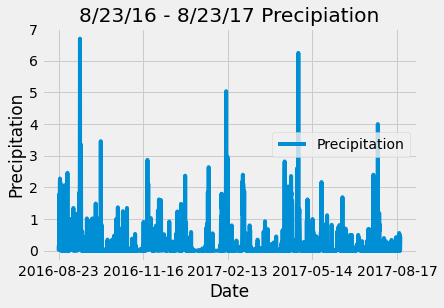

In [55]:
# Use Pandas Plotting with Matplotlib to plot the data

prcplot = PRCP_DF.plot('Date', 'Precipitation')
plt.title("8/23/16 - 8/23/17 Precipiation")
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.savefig("Images/Preciplot.png")

In [56]:
# Use Pandas to calcualte the summary statistics for the precipitation data
PRCP_DF.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [57]:
#Before i do anything I want to again know the column names and their what their types are. Im reusing the code I use from on top

inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])






id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [83]:
# Design a query to calculate the total number stations in the dataset
session.query(func.count(station.station)).all()

# I wanted to figure out how to count the the stations using the distinct method, but i couldnt figure out how to form the syntax for it.



[(9)]

In [91]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)

ACstation = session.query(measurement.station, func.count(measurement.station)).\
    group_by(measurement.station).order_by( func.count(measurement.station).desc()).all()

print(ACstation)
# List the stations and the counts in descending order.


[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [103]:
#Figure out whats the most Active stations. Judging from the out above it is USC00519281 with 2772 times it appeared. So lets capture that.

# Sincethe query was returned to me as a dictionary. The most active would have an index of [0] [0]. To get the least it would be [8][0].
MactiveS = ACstation[0][0]


LactiveS = ACstation[8][0]

print(f"The most active station is " + MactiveS + ". ")
print(f"The least active station is " + LactiveS + ". ")


The most active station is USC00519281. 
The least active station is USC00518838. 


In [165]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

#im assuming the temperature is tobs. since its the only data we didnt work on yet. And after looking at the bonus section. My assumption is right. 
TempMActStation= session.query(func.avg(measurement.tobs), func.max(measurement.tobs), func.min(measurement.tobs)).\
       filter(measurement.station == MactiveS).all()
TempMActStation



#Create a for statement to capture those temperature in readable and printable form. By excluding this step we will only see numbers without meaning. 
# The order of the query was Average, highest, and lowest. The capture data has to in that order in the For statement initially. but in printing, that order does not matter since the 3 variables already captured those values.


for AvgTemp, hightemp, lowtemp in TempMActStation:
    print(f'The lowest temperature is  {lowtemp}.')
    print(f'The highest temperature is  {hightemp}.')
    print(f'The Average temperature is {AvgTemp}.')

# I really want to know how to round that AvgTemp while in the loop. i




The lowest temperature is  54.0.
The highest temperature is  85.0.
The Average temperature is 71.66378066378067.


In [ ]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


# Close session

In [ ]:
# Close Session
session.close()